### 샤프 지수(Sharpe Ratio) 이용한 포트폴리오 최적화
- 위험 대비 성과 측정 지표
- Sharpe = (포트폴리오 평균 수익률 - 무위험 이자율) / 포트폴리오 수익률 표준편차


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pykrx import stock


### 개별 종목 머지

In [44]:
start_date = '20200101'
end_date = '20211231'
symbols = ['035420', '196170', '042700', '005930'] # Naver, 알테오젠, 한미반도체, 삼전

In [45]:
# dataFrame concat와 동일


df_stock = pd.DataFrame()
for symbol in symbols:
    df_stock[symbol] = stock.get_market_ohlcv_by_date(start_date, end_date, symbol)['종가']
df_stock

,035420,196170,042700,005930
날짜,,,,
2020-01-02,182500,19413,3980,55200
2020-01-03,181500,18746,3985,55500
2020-01-06,180500,17494,3920,55500
2020-01-07,187000,17995,3925,55800
2020-01-08,183000,16883,3925,56800
...,...,...,...,...
2021-12-24,384000,58389,18050,80500
2021-12-27,380500,59807,18300,80200
2021-12-28,384500,62809,18425,80300


In [46]:
# 데일리 수익율
daily_return = df_stock.pct_change(periods=1)
daily_return

,035420,196170,042700,005930
날짜,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.005479,-0.034358,0.001256,0.005435
2020-01-06,-0.005510,-0.066788,-0.016311,0.000000
2020-01-07,0.036011,0.028638,0.001276,0.005405
2020-01-08,-0.021390,-0.061795,0.000000,0.017921
...,...,...,...,...
2021-12-24,0.015873,-0.014082,0.000000,0.007509
2021-12-27,-0.009115,0.024285,0.013850,-0.003727
2021-12-28,0.010512,0.050195,0.006831,0.001247


In [47]:
# 리스크 정수 구하기 
annual_return = daily_return.mean() * 252
annual_return

035420    0.437258
196170    0.883705
042700    0.946450
005930    0.217409
dtype: float64

In [48]:
daily_cov = daily_return.cov()
daily_cov

,035420,196170,042700,005930
035420,0.000526,0.000409,0.000260,0.000159
196170,0.000409,0.002319,0.000473,0.000185
042700,0.000260,0.000473,0.001220,0.000283
005930,0.000159,0.000185,0.000283,0.000315


In [49]:
# weight 비중

annual_cov = daily_cov * 252
annual_cov


,035420,196170,042700,005930
035420,0.132514,0.102990,0.065583,0.039966
196170,0.102990,0.584310,0.119117,0.046511
042700,0.065583,0.119117,0.307320,0.071432
005930,0.039966,0.046511,0.071432,0.079495


### 비율 생성과 정규화


In [50]:
import numpy as np

weights = np.random.random(len(symbols)) # 비율 랜덤생성기
# weights, type(weights), weights.shape

In [51]:
weights = weights /  np.sum(weights)
weights, type(weights), np.sum(weights)

(array([0.37259981, 0.10479503, 0.21863675, 0.30396841]), numpy.ndarray, 1.0)

In [52]:
returnOfRate = np.dot(weights, annual_return)
returnOfRate, type(returnOfRate)
risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))

In [53]:
np.dot(annual_cov, weights)

array([0.08665455, 0.13978801, 0.12582363, 0.05954691])

In [54]:
np.dot(weights.T, np.dot(annual_cov, weights))

0.09254660771159534

In [55]:
# 여러 포트폴리오 비율 적용

portfolio_returnOfRate = list()
portfolio_risks = list()
portfolio_weights = list()
sharpe_ratio = list()

for number in range(200):

    weights = np.random.random(len(symbols)) # 비율 랜덤생성기
    weights = weights /  np.sum(weights)
    returnOfRate = np.dot(weights, annual_return)
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))


    portfolio_weights.append(weights)
    portfolio_returnOfRate.append(returnOfRate)
    portfolio_risks.append(risk)
    sharpe_ratio.append(returnOfRate / risk)

In [56]:
# Convert DataFrame : Return Of Rate, Risk, Weights
portfolio = {"ReturnOfRate": portfolio_returnOfRate,
            "Risk" : portfolio_risks
            , 'Sharpe' : sharpe_ratio}

for idx, symbol in enumerate(symbols):
    portfolio[symbol] = [weight[idx] for weight in portfolio_weights]

    pass

df_portfolio = pd.DataFrame(portfolio)
df_portfolio.head(3)

,ReturnOfRate,Risk,Sharpe,035420,196170,042700,005930
0,0.615411,0.422894,1.455238,0.603021,0.370180,0.025758,0.001041
1,0.640760,0.392115,1.634113,0.184882,0.364788,0.191551,0.258779
2,0.826473,0.445702,1.854316,0.053893,0.239972,0.599861,0.106274


In [59]:
# df_portfolio['Sharpe'].max()
max_index = df_portfolio['Sharpe'].idxmax()
df_portfolio.iloc[max_index]

ReturnOfRate    0.808885
Risk            0.425868
Sharpe          1.899380
035420          0.229552
196170          0.219956
042700          0.541058
005930          0.009434
Name: 38, dtype: float64

In [62]:
# 위험도 감소
df_portfolio['Risk'].min()
idx_min_risk= df_portfolio.iloc[df_portfolio['Risk'].idxmin()]

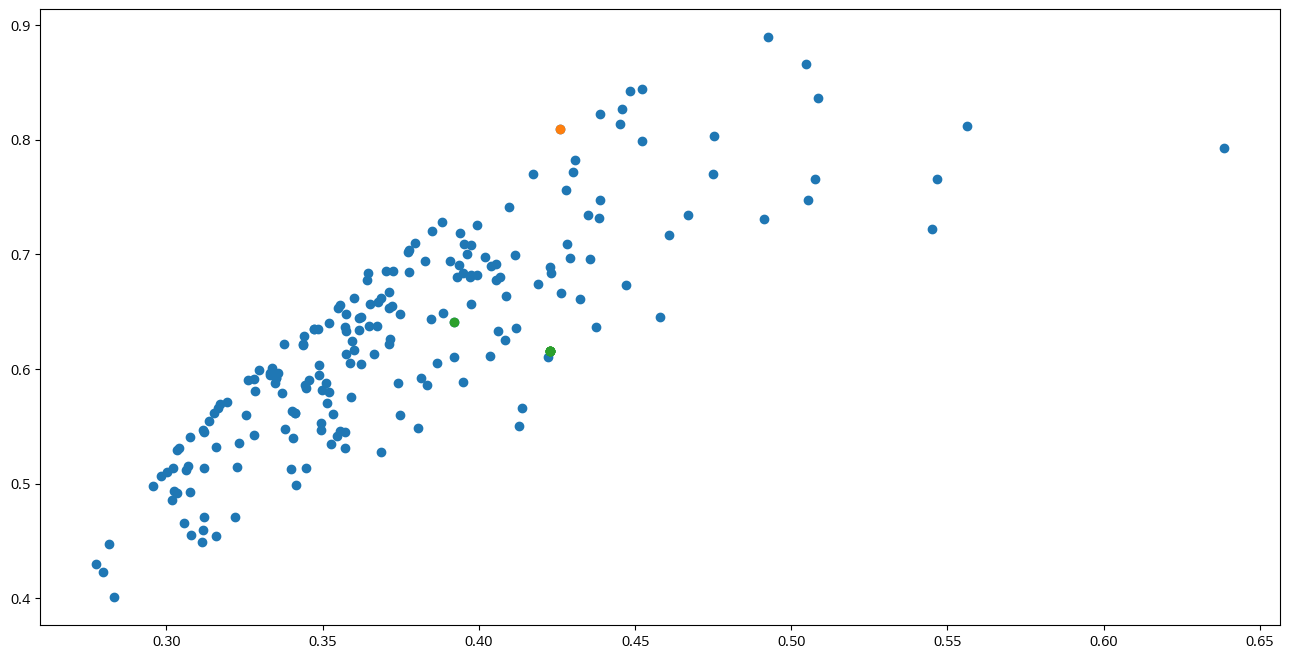

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.scatter(x=df_portfolio['Risk'], y=df_portfolio['ReturnOfRate'])
plt.scatter(x=df_portfolio.iloc[max_index]['Risk'], y=df_portfolio.iloc[max_index]['ReturnOfRate'])
plt.scatter(x=df_portfolio.iloc[idx_min_risk]['Risk'], y=df_portfolio.iloc[idx_min_risk]['ReturnOfRate'])
plt.show()